# Image-to-line endpoint 학습을 위한 데이터 추출기

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pdb


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import SGD
from torch.utils.data import Dataset
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                               hflip, vflip, crop)

from PIL import Image
from IPython.display import display
from utils import plot_cells, plot_masks, plot_mask_cells, convert_cell_to_img

torch.manual_seed(0);

## 폴더에서 image와 mask의 경로를 추출

In [2]:
def get_jpg_files(folder):
    """폴더 내의 모든 JPG 파일의 이름을 반환합니다."""
    return {f for f in os.listdir(folder) if f.endswith('.jpg')}

def find_common_files(folder1, folder2):
    """두 폴더 내에 동일한 이름을 가진 JPG 파일의 리스트를 반환합니다."""
    files1 = get_jpg_files(folder1)
    files2 = get_jpg_files(folder2)
    common_files = files1 & files2
    return list(common_files)

# 폴더 경로를 설정합니다.
folder1 = os.path.join('data','image')
folder2 = os.path.join('data','mask')

# 동일한 이름을 가진 JPG 파일 리스트를 추출합니다.
common_jpg_files = find_common_files(folder1, folder2)

print(f"Common JPG files:{len(common_jpg_files)}")
for file in common_jpg_files[:3]:
    print(file)

Common JPG files:206
frame_0071_part_2_time_33.13.jpg
frame_0056_part_3_time_26.13.jpg
frame_0043_part_2_time_20.07.jpg


In [3]:
class CellsDataset(Dataset):
    """Constructs cell dataset"""
    def __init__(self, sample_dirs):
        super().__init__()
        self.sample_dirs = sample_dirs

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        img_fn = os.path.join('data','image',sample_dir.name)
        mask_fn = os.path.join('data','mask',sample_dir.name)

        image, mask = Image.open(img_fn).convert('RGB'), Image.open(mask_fn).convert('L')
        assert image.size == mask.size
        return image, mask, sample_dir.name

In [33]:
# Training, validation sample 분할
train_dirs = [Path(d) for d in common_jpg_files[16:]]
valid_dirs = [Path(d) for d in common_jpg_files[:16]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

img0, mask0, _ = train_cell_ds[0]
#display(img0)
train_dirs[:1], img0.size, type(mask0), valid_dirs[:1]

([WindowsPath('frame_0095_part_2_time_44.33.jpg')],
 (1080, 640),
 PIL.Image.Image,
 [WindowsPath('frame_0071_part_2_time_33.13.jpg')])

## 데이터에서 특정 사이즈(256x256)의 image, mask의 patch 추출¶

In [42]:
# Test for calculate_bboxes
steps_h = chain(range(0, 1080-256, 256), [1080-256])
steps_w = chain(range(0, 640-256, 256), [640-256])
a2 = [bb for bb in steps_h]
a3 = [bb for bb in steps_w]
idx_bboxes = list(zip_longest([], product(a2, a3), fillvalue=(2,3)))
a2, a3, idx_bboxes[:3], 

([0, 256, 512, 768, 824],
 [0, 256, 384],
 [((2, 3), (0, 0)), ((2, 3), (0, 256)), ((2, 3), (0, 384))])

In [23]:
def calcuate_bboxes(im_shape, patch_size):
    """Calculate bound boxes based on image shape and size of the bounding box
    given by `patch_size`"""
    h, w = im_shape  # 640,1080
    ph, pw = patch_size  # 256,256
    # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
    steps_h = chain(range(0, h - ph, ph), [h - ph]) 
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class PatchedDataset(Dataset):
    """Creates patches of cells.

    Parameters
    ----------
    base_dataset: CellsDataset
        Dataset of cells
    patch_size: tuple of ints (default=(256, 256))
        The size of each patch
    random_flips: bool (default=False)
        If true, patches and masks will be randomly flipped horizontally and
        vertically.
    padding: int (default=16)
        Amount of paddding around each image and mask
    """
    def __init__(self,
                 base_dataset,
                 patch_size=(256, 256),
                 random_flips=False,
                 padding=16):
        super().__init__()
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)
        self.padding = padding
        self.random_flips = random_flips
        
        self.line_coordinates = line_endpoint(os.path.join('data','labels_line.csv'))

        coords = []
        '''
        (256x256)크기로 mask이미지를 띁어낼 좌표 계산
        0 (256, 256) [(0, (0, 0))]    [(0, (0, 0))]
        1 (256, 256) [(1, (0, 0))]    [(0, (0, 0)), (1, (0, 0))]
        3 (320, 256) [(3, (0, 0)), (3, (0, 64))]    [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64))]
        9 (696, 520) [(9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)), (9, (256, 256)), (9, (256, 440)), ...] 
                     [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64)), (4, (0, 0)), ..., (9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)),...]        
        '''
        for idx, (_, mask, fname) in enumerate(self.base_dataset):
            w, h = mask.size
            bboxes = calcuate_bboxes((h, w), self.patch_size)
            idx_bboxes = list(zip_longest([], bboxes, fillvalue=idx))
            new_lines = recalc_line(idx_bboxes, self.line_coordinates[fname])  ########
            idx_bboxes = [(idx, posi, []) for idx,posi in idx_bboxes]  #########
            #pdb.set_trace()
            list(map(lambda x: idx_bboxes[x[0]][2].append(x[1:]), new_lines))  #########
            coords.extend(idx_bboxes)
            #print(idx, fname, mask.size, idx_bboxes, len(coords), self.line_coordinates[fname])
        self.coords = coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        #pdb.set_trace()
        img_idx, (i, j), pts = self.coords[idx]  # idx(=4): 3,(0,64)
        cell, mask, fname = self.base_dataset[img_idx]  # (320,256),(320,256)
        h, w = self.patch_size_expanded  # (288,288),288=256+2x16
        # if idx==4:  # 4 3 0 64 (320, 256) (320, 256)
        #     print(idx, img_idx, i, j, cell.size, mask.size)
        #     pdb.set_trace()

        cell = pad(cell, self.padding, padding_mode='reflect')
        mask = pad(mask, self.padding, padding_mode='reflect')

        cell = crop(cell, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        #if len(pts)>0:
        #    pdb.set_trace()
        new_lines = []
        if self.random_flips:
            if random.random() < 0.5:
                cell = hflip(cell)
                mask = hflip(mask)
                pts = [hflip_coordinates(pt[:2],pt[2:]) for pt in pts]
                #if len(pts)>0:
                #    pdb.set_trace()

            if random.random() < 0.5:
                cell = vflip(cell)
                mask = vflip(mask)
                pts = [vflip_coordinates(pt[:2],pt[2:]) for pt in pts]

        cell = to_tensor(cell)  ########## 아래: 정규화가 중요(mask를 255로 나누어 0~1로)
        mask = torch.as_tensor(np.array(mask).astype('float32')/255.0)
        #mask = torch.as_tensor((np.array(mask) == 255).astype('float32'))

        # mean and std of imagenet
        cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return cell, mask, pts

In [24]:
train_ds = PatchedDataset(train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)

In [35]:
for idx, aa in enumerate(train_ds):
    print(aa[0].shape, aa[1].shape, aa[2])  # aa[0]:(3,288,288), aa[1]:(288,288)
    if idx==0:
        break

torch.Size([3, 288, 288]) torch.Size([288, 288]) [(11, 0, 6, 256)]


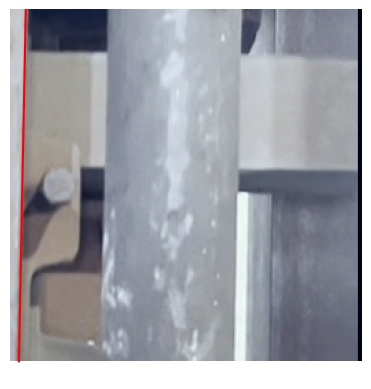

In [36]:
def show_tensor_image(tensor_image, lines=None):
    """
    Display a tensor image with optional lines.
    
    Parameters:
    - tensor_image: torch.Tensor, image tensor of shape (3, 256, 256)
    - lines: list of tuples, each containing start and end points of a line ((x1, y1), (x2, y2))
    """
    # Convert the tensor to a NumPy array
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    plt.imshow(np_image)
    
    # Plot lines if provided
    if lines is not None:
        for line in lines:
            start, end = line[:2],line[2:]
            x_values = [start[0], end[0]]
            y_values = [start[1], end[1]]
            plt.plot(x_values, y_values, 'r')  # 'r' is the color red
    
    plt.axis('off')  # Turn off axis
    plt.show()


#lines = [((127, 0), (102, 255))]

# Display the image with lines
show_tensor_image(aa[0][:, 16:-16, 16:-16], aa[2])

In [ ]:
#rgb_image = aa[1][16:-16,16:-16].to(torch.int32).numpy()
rgb_image = aa[1].to(torch.int32).numpy()

# 이미지 시각화
# plt.imshow(rgb_image)
# plt.title("RGB Image")
# plt.show()

In [10]:
def line_endpoint(csv_fname):
    df = pd.read_csv(csv_fname, header=None)
    df.columns = ['type', 'x1', 'y1', 'x2', 'y2', 'filename', 'height', 'width']

    line_coordinates = {}
    for index, row in df.iterrows():
        jpg_filename = row['filename']  # 'filename' 열에서 JPG 파일명 추출
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']  
        if jpg_filename not in line_coordinates:
            line_coordinates[jpg_filename] = []
        line_coordinates[jpg_filename].append((x1, y1, x2, y2))
        
    return line_coordinates


line_coordinates = line_endpoint(os.path.join('data','labels_line.csv'))
for filename, coords in line_coordinates.items():
    print(f"{filename}: {coords}")
    break

frame_0041_part_1_time_19.13.jpg: [(219, 0, 224, 458), (813, 0, 831, 452)]


In [ ]:
cell, mask, fname = train_cell_ds[0]
cell.size, mask.size, line_coordinates[fname]

In [9]:
def recalc_line(patches, lines):
    """
    Calculate the new coordinates of the lines within the cropped images defined by patches.

    Parameters:
    - patches: list of tuples, each containing an index and a tuple of (row, column) for the crop
    - lines: list of tuples, each containing the (x1, y1, x2, y2) coordinates of a line

    Returns:
    - new_lines: list of tuples, each containing the patch index and the new (x1, y1, x2, y2) coordinates within the cropped image
    """
    new_lines = []

    for idx, (_, (rr, cc)) in enumerate(patches):
        for line in lines:
            c1, r1, c2, r2 = line
            sp, ep = reposition_line(r1,c1,r2,c2, po=(rr,cc)) 
            
            if 0 < sp[0] < 255 and 0 < ep[0] < 255:
                new_lines.append((idx, *sp, *ep))

    return new_lines

# Example usage
patches = [(0, (0, 0)), (0, (0, 256)), (0, (0, 512)), (0, (0, 768)), (0, (0, 824)),
           (0, (256, 0)), (0, (256, 256)), (0, (256, 512)), (0, (256, 768)), (0, (256, 824)),
           (0, (384, 0)), (0, (384, 256)), (0, (384, 512)), (0, (384, 768)), (0, (384, 824))]
lines = [(252, 0, 260, 640), (870, 0, 895, 640)]


#y_value = calculate_y_on_line(x1, y1, x2, y2, x_value)

new_lines = recalc_line(patches, lines)
new_lines

[(0, 252, 0, 255, 256),
 (3, 102, 0, 112, 256),
 (4, 46, 0, 56, 256),
 (8, 112, 0, 122, 256),
 (9, 56, 0, 66, 256),
 (11, 1, 0, 4, 256),
 (13, 117, 0, 127, 256),
 (14, 61, 0, 71, 256)]

In [ ]:
patches = [(0, (0, 0)), (0, (0, 256)), (0, (0, 512)), (0, (0, 768)), (0, (0, 824)), (0, (256, 0)), (0, (256, 256)), (0, (256, 512)), (0, (256, 768)), (0, (256, 824)), (0, (384, 0)), (0, (384, 256)), (0, (384, 512)), (0, (384, 768)), (0, (384, 824))]
new_lines = [(3, (102, 0, 127, 256)), (4, (46, 0, 71, 256)), (8, (102, 0, 127, 256)), (9, (46, 0, 71, 256)), (13, (102, 0, 127, 256)), (14, (46, 0, 71, 256))]

patches = [(idx,posi,[]) for idx,posi in patches]
list(map(lambda x: patches[x[0]][2].append(x[1]), new_lines))
    
patches    

In [8]:
def hflip_coordinates(start, end, image_width=256):
    """
    Apply horizontal flip to the coordinates of a line in an image.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_width: int, width of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the horizontal flip
    - new_end: tuple, new (x2, y2) coordinates after the horizontal flip
    """
    new_x1 = image_width - 1 - start[0]
    new_y1 = start[1]
    new_x2 = image_width - 1 - end[0]
    new_y2 = end[1]

    new_start = (new_x1, new_y1)
    new_end = (new_x2, new_y2)

    return *new_start, *new_end

# 예제 사용
original_start = (102, 0)
original_end = (127, 256)

new_line = hflip_coordinates(original_start, original_end)
new_line

(153, 0, 128, 256)

In [7]:
def vflip_coordinates(start, end, image_height=256):
    """
    Apply vertical flip to the coordinates of a line in an image and swap start and end points.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_height: int, height of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the vertical flip
    - new_end: tuple, new (x2, y2) coordinates after the vertical flip
    """
    new_x1 = start[0]
    new_y1 = image_height - 1 - start[1]
    new_x2 = end[0]
    new_y2 = image_height - 1 - end[1]

    # Ensure coordinates are within the bounds of the image
    new_y2 = max(0, new_y2)

    # Swap the coordinates
    new_start = (new_x2, new_y2)
    new_end = (new_x1, new_y1)

    return *new_start, *new_end

# 예제 사용
original_start = (102, 0)
original_end = (127, 256)

new_line = vflip_coordinates(original_start, original_end)
new_line

(127, 0, 102, 255)

In [6]:
def calculate_y_on_line(x1, y1, x2, y2, x):
    if x1 == x2:
        raise ValueError("The line is vertical, y coordinate cannot be determined by x coordinate alone.")

    m = (y2 - y1) / (x2 - x1)
    #y = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
    y = m * x + y1
    y_rounded = int(y + 0.5) if y - int(y) >= 0.5 else int(y)
    return y_rounded


def reposition_line(r1,c1,r2,c2, po=(0,0), im_size=(256,256)):
    rs = [po[0], po[0]+im_size[0]]
    cs = [calculate_y_on_line(r1,c1,r2,c2,r)-po[1] for r in rs]
    out = [(c,r) for c,r in zip(cs,[0,im_size[0]])]
    return out


r1, c1 = 0, 870  # start pt of line
r2, c2 = 640, 895  # end of line

out = reposition_line(r1,c1,r2,c2, po=(256,768))
print(out)

[(112, 0), (122, 256)]
